# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [134]:
# Importacion de librerias 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb


In [ ]:
#Importar dataset y vista general
df = pd.read_csv('data/taxi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Observamos que no hay datos nulos por lo que no tenemos que hacer imputacion pero el tipo de dato en datetime esta incorrecto por lo que para una mejor manejabilidad del dataset vamos a pasar el datetime a datetime64 y posteriormente el indice de la tabla como la columna con la fecha.

In [136]:
# Cambio de tipo de dato en columna 'datetime' a datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Confirmacion de que el cambio se realizo correctamente
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [137]:
# Declaramos el indice de la tabla como datetime
df.set_index('datetime', inplace=True)

# Comprobamos que el indice se ha establecido correctamente
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [138]:
# Verificamos que el indice con datetime este en orden
print(df.index.is_monotonic_increasing)

True


<Axes: xlabel='datetime'>

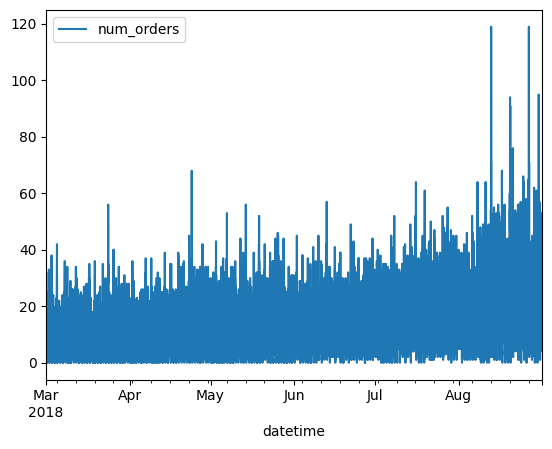

In [139]:
# Grafico de la serie temporal
df.plot()

Haremos un remuestreo para cada hora ya que el objetivo es predecir el numero de pedido de taxis para la siguiente hora

In [140]:
# Remuestreo de serie temporal 
df = df.resample('1h').sum()

# Cofirmacion de remuestreo por hora
print(df.head())    

df.info()


                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Análisis

Realizaremos un analisis de la media movil, tendencias y estacionalidad.

<Axes: xlabel='datetime'>

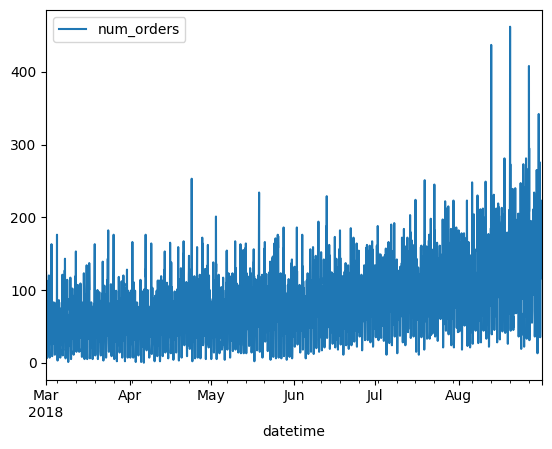

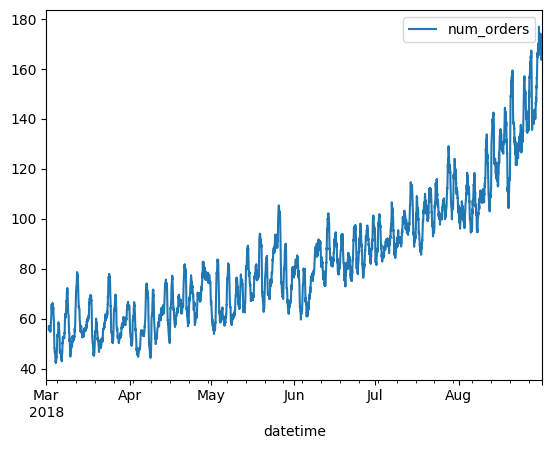

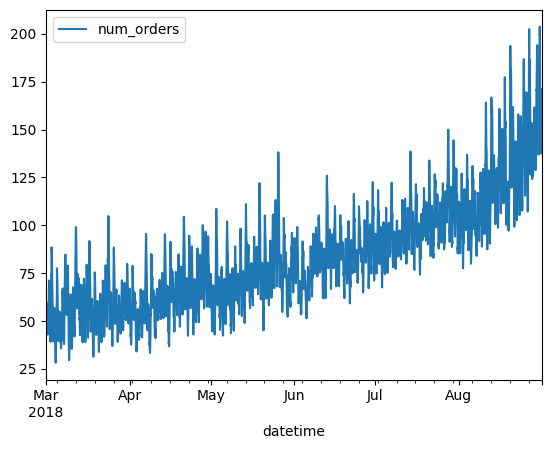

In [141]:
# Definimos la media movil de 24 horas para graficar la tendencia
media_24hrs = df.rolling(24).mean()

# Definimos la media movil de 6 horas para graficar la tendencia
media_12hrs = df.rolling(12).mean()

# Graficamos la serie temporal y las medias movil
df.plot(label='Original')
media_24hrs.plot(label='Media movil 24 horas')
media_12hrs.plot(label='Media movil 12 horas')

Podemos observar con la media movil un tendencia ascendente de marzo hacia agosto, donde podemos deducir que en junio-julio hay mas demanda de taxis por la temporada de vacaiones 

Ahora usaremos seasonal_decompose para poder observar las graficas de las tendencias y estacionalidad dopnde los analizaremos por semana para poder reducir el ruido y obtener conclusiones

<Axes: xlabel='datetime'>

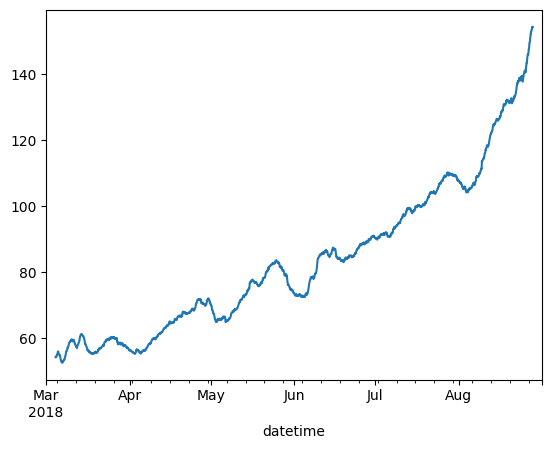

In [142]:
# Descomponemos la serie temporal
decomposed = seasonal_decompose(df, period=168)

# Graficamos la tedencia
decomposed.trend.plot()

Como ya habiamos oberservado con la media movil la tendencia es ascendente con mayor fuerza en los meses de julio-Agosto

<Axes: xlabel='datetime'>

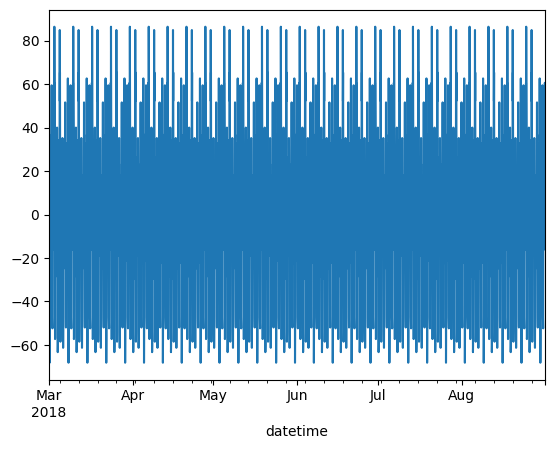

In [143]:
# Graficamos la estacionalidad
decomposed.seasonal.plot()

Con este grafico de estacionalidad podemos concluir que en ciertos dias como podria ser fines de semana puede llegar a un aumento hasta 80 por encima de la tendencia promedia o puede disminuir hasta por 60 por debajo de la tendencia promedio como en dias martes o miercoles que hay menos vuelos y por lo tanto se ocupan menos taxis

## Formación

Para el entrenamiento del modelo primero vamos a definir las caracteristicas, realizaremos la division del conjunto de entrenamiento y prueba
Posteriormente entrenaremos diferentes modelos con diferentes hiperparametros buscando uno que tenga la mejor prediccion con el conjunto de entrenamiento para la metrica RMSE.

In [144]:
# Funcion para crear las variables de lag y rolling mean
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [145]:
# Aplicamos la funcion a los datos para obtener las caracteristicas de 14 dias y la media movil de 6 horas
make_features(df, 24, 12)
print(df.head())

                     num_orders  month  day  dayofweek  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-01 00:00:00         124      3    1          3    NaN    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3  124.0    NaN    NaN   
2018-03-01 02:00:00          71      3    1          3   85.0  124.0    NaN   
2018-03-01 03:00:00          66      3    1          3   71.0   85.0  124.0   
2018-03-01 04:00:00          43      3    1          3   66.0   71.0   85.0   

                     lag_4  lag_5  lag_6  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN 

In [146]:
# Separamos los datos en train y test
train, test = train_test_split(df, test_size=0.1, shuffle=False)

# Eliminamos las filas con valores nulos
train.dropna(inplace=True)

# Seleccionamos las carateristicas y objetivos de train y test
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']


Entrenamiento de Modelo de Regresio lineal 

In [147]:
# Creamos el modelo de regresion lineal
lr = LinearRegression()
# Entrenamos el modelo con los datos de train
lr.fit(features_train, target_train)
# Predecimos los datos de train
predictions_train = lr.predict(features_train)
# Evaluamos el RMSE del modelo
print('RMSE de Regresion lineal en entrenamiento:', sqrt(mean_squared_error(target_train, predictions_train)))


RMSE de Regresion lineal en entrenamiento: 25.818602103995378


Entrenamiento de Modelo Random Forest buscando mejores hiperparametros con RandomSearchCV 


In [148]:
# Definimos parametros para buscar mejores hiperparametros con RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Definimos modelo de Random Forest
rf = RandomForestRegressor(random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,
    cv=6,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
)

# Entrenamos RandomizedSearchCV con los datos de entrenamiento
random_search.fit(features_train, target_train)

# Imprimimos los mejores hiperparametros y el mejor score
print("Mejores hiperparametros:", random_search.best_params_)
print("Mejor score:", random_search.best_score_)

Fitting 6 folds for each of 25 candidates, totalling 150 fits
Mejores hiperparametros: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 195}
Mejor score: -23.75782463729068


In [149]:
# Creamos el modelo de Random Forest con los mejores hiperparametros
rf_best = RandomForestRegressor(
    n_estimators=random_search.best_params_['n_estimators'],
    max_depth=random_search.best_params_['max_depth'],
    min_samples_split=random_search.best_params_['min_samples_split'],
    min_samples_leaf=random_search.best_params_['min_samples_leaf'],
    random_state=42
)

# Entrenamos el modelo con los datos de train
rf_best.fit(features_train, target_train)

# Evaluamos el RMSE del modelo
predictions_train = rf_best.predict(features_train)
print('RMSE de Random Forest en entrenamiento:', sqrt(mean_squared_error(target_train, predictions_train)))

RMSE de Random Forest en entrenamiento: 10.128980780860587


Entrenamiento de Modelo XGBoost buscando mejores hiperparametros con RandomSearchCV

In [150]:
# Definimos parametros para buscar mejores hiperparametros con RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 300),          # Número de árboles
    'max_depth': randint(3, 10),                # Profundidad máxima de los árboles
    'learning_rate': uniform(0.01, 0.3),        # Tasa de aprendizaje
    'subsample': uniform(0.6, 0.4),             # Fracción de muestras usadas por árbol
    'colsample_bytree': uniform(0.6, 0.4),      # Fracción de columnas usadas por árbol
    'min_child_weight': randint(1, 6),          # Peso mínimo de los nodos hijos
    'gamma': uniform(0, 0.5)                    # Penalización por división
}

# Definimos modelo de XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,                          # Número de combinaciones a probar
    cv=6,                            # Validación cruzada para series temporales
    scoring='neg_root_mean_squared_error',  # Usamos RMSE negativo
    verbose=1,
    n_jobs=-1,                          # Usa todos los núcleos de la CPU
)

# Entrenamos RandomizedSearchCV con los datos de entrenamiento
random_search.fit(features_train, target_train)

# Imprimimos los mejores hiperparametros y el mejor score
print("Mejores hiperparametros:", random_search.best_params_)
print("Mejor score:", random_search.best_score_)

Fitting 6 folds for each of 25 candidates, totalling 150 fits
Mejores hiperparametros: {'colsample_bytree': np.float64(0.7820270454490904), 'gamma': np.float64(0.16460193505408444), 'learning_rate': np.float64(0.02942024994679872), 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 293, 'subsample': np.float64(0.6872379990165942)}
Mejor score: -23.020979563395183


In [151]:
# Creamos el modelo de XGBoost con los mejores hiperparametros
xgb_best = xgb.XGBRegressor(
    n_estimators=random_search.best_params_['n_estimators'],
    max_depth=random_search.best_params_['max_depth'],
    learning_rate=random_search.best_params_['learning_rate'],
    subsample=random_search.best_params_['subsample'],
    colsample_bytree=random_search.best_params_['colsample_bytree'],
    min_child_weight=random_search.best_params_['min_child_weight'],
    gamma=random_search.best_params_['gamma'],
    objective='reg:squarederror',
    random_state=42
)
# Entrenamos el modelo con los datos de train
xgb_best.fit(features_train, target_train)

# Evaluamos el RMSE del modelo
predictions_train = xgb_best.predict(features_train)
print('RMSE de XGBoost en entrenamiento:', sqrt(mean_squared_error(target_train, predictions_train)))

RMSE de XGBoost en entrenamiento: 9.606037434873722


Podemos concluir que el que mejor resultados con RMSE fue el modelo de Random Forest por lo cual usaremos ese modelo para predecir los objetivos del conjunto de prueba para poder encontrar un RMSE menor a 48 que es nuestro objetivo.

## Prueba

In [152]:
# Predecimos los datos de test con el modelo de Random Forest
predictions_test_rf = rf_best.predict(features_test)
# Evaluamos el RMSE del modelo
print('RMSE de Random Forest en test:', sqrt(mean_squared_error(target_test, predictions_test_rf)))
# Predecimos los datos de test con el modelo de XGBoost
predictions_test_xgb = xgb_best.predict(features_test)
# Evaluamos el RMSE del modelo
print('RMSE de XGBoost en test:', sqrt(mean_squared_error(target_test, predictions_test_xgb)))
# Predecimos los datos de test con el modelo de regresion lineal
predictions_test_lr = lr.predict(features_test)
# Evaluamos el RMSE del modelo
print('RMSE de regresion lineal en test:', sqrt(mean_squared_error(target_test, predictions_test_lr)))

RMSE de Random Forest en test: 42.447698384295514
RMSE de XGBoost en test: 42.73542617537147
RMSE de regresion lineal en test: 45.529337080209366


Al obtener el resultado del modelo Random Forest con los datos de prueba observamos que no llegaba al RMSE que era nuetrso objetivo por lo que lo comparamos con los otros modelos, nos percatamos que algunos tenian mejor metrica de RMSE pero ninguno se acercaba a estar por debajo de por lo que tuvimos que recuerrir a incrementar las caracteristicas obteniendo ahora 24 caracteristica que son las 24 horas antes de cada fila, con ello pudimos obtener los ultimos valores donde podemos ver que el que mejor predice es el modelo XGBoost aunque Random Forest tiene muy poco diferencia si tuvieramos que agregar en el objetivo la velocidad de entrenamiento XGBoost seria la opcion ideal.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48